In [2]:
from rag_module.rag import RAG, Embedder
import mlflow
import inspect
import pandas as pd
import os
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# set path to database
os.environ["embedding_path"] = "./embeddings/ELOQ_news_partial_2/"

# load eval data
silver = pd.read_csv("eval_data/ScopeQA/ELOQ_silver.csv")
gold = pd.read_csv("eval_data/ScopeQA/ELOQ_gold.csv")

print(f'n queries silver: {len(silver)}')
print(f'n queries gold: {len(gold)}')

c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


n queries silver: 18820
n queries gold: 216


In [3]:
# add labels to eval data
embedder = Embedder(model_name="all-MiniLM-L6-v2")
database_filenames = set(chunk['filename'] for chunk in embedder.chunkdata)
database_cats = set(x.split('_')[0] for x in database_filenames)

def add_old_label(df, database_filenames):
    """
    Add 'in_database' and 'label' columns to the ScopeQA dataset.
    - 'in_database': whether the document appears in the known database filenames.
    - 'label':
        - 0: query relates to a document in the database and is answerable
        - 1: query relates to a document in the database but is not answerable
        - 2: query relates to a document not in the database
    """
    df['in_database'] = df['doc_id'].isin(database_filenames)
    
    df['label'] = 2
    df.loc[df['in_database'] & (df['llm_confusion_label'] == 'no'), 'label'] = 0
    df.loc[df['in_database'] & (df['llm_confusion_label'] == 'yes'), 'label'] = 1

def add_unrelated_label(df, database_cats):
    """
    Add label to indicate if a query is unrelated to the database, based on if the topic is in the database.
    """
    df['category'] = df['doc_id'].apply(lambda x: x.split('_')[0])
    df['unrelated'] = df['category'].apply(lambda x: 1 if x not in database_cats else 0)

def add_answerable_label(df, database_filenames):
    """
    Add label to indicate if a query is answerable, based on if the document is in the database.
    """
    df['answerable'] = df['doc_id'].isin(database_filenames).astype(int)

def add_label(df):
    """
    Add labels to the dataframe based on the document ID and database filenames.
    """
    df['label'] = 1
    df.loc[(df['answerable'] == 1), 'label'] = 0
    df.loc[(df['unrelated'] == 1), 'label'] = 2

In [4]:
add_unrelated_label(silver, database_cats)
add_unrelated_label(gold, database_cats)
add_answerable_label(silver, database_filenames)
add_answerable_label(gold, database_filenames)
add_label(silver)
add_label(gold)

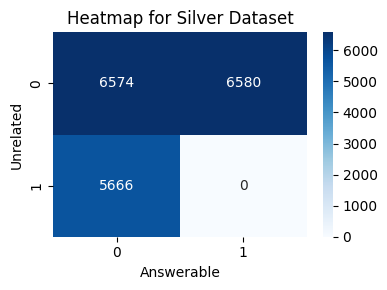

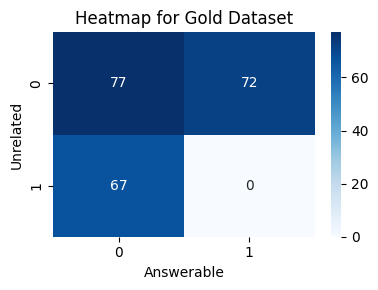

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, title):
    # Create a pivot table for the heatmap
    heatmap_data = df.pivot_table(index='unrelated', columns='answerable', aggfunc='size', fill_value=0)

    # Plot the heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title(title)
    plt.xlabel('Answerable')
    plt.ylabel('Unrelated')
    plt.tight_layout()
    plt.show()

# Plot heatmaps for silver and gold
plot_heatmap(silver, title="Heatmap for Silver Dataset")
plot_heatmap(gold, title="Heatmap for Gold Dataset")

In [5]:
# Create train and test sets

sample_method = 'sample'
n_train = 9999
n_test = 9999
label_col = 'label'
ignore_confusion = True

if ignore_confusion:
    silver = silver[silver['llm_confusion_label'] == 'no']
    gold = gold[gold['llm_confusion_label'] == 'no']

n_train = min(n_train, len(silver))
n_test = min(n_test, len(gold))

def balanced_sample(df, label_col, n_total, random_state=1):
    n_classes = df[label_col].nunique()
    n_per_class = n_total // n_classes
    
    # Initialize an empty DataFrame to store results
    result = pd.DataFrame()
    
    # For each class, sample and append to result
    for label_value, group in df.groupby(label_col):
        sampled = group.sample(n=min(n_per_class, len(group)), random_state=random_state)
        result = pd.concat([result, sampled])
    
    # Reset index without shuffling
    result = result.reset_index(drop=True)
    
    return result

if sample_method == 'balance':
    trainset = balanced_sample(silver, label_col, n_total=n_train)
    testset = balanced_sample(gold, label_col, n_total=n_test)
elif sample_method == 'sample':
    trainset = silver.sample(n=n_train, random_state=1).reset_index(drop=True)
    testset = gold.sample(n=n_test, random_state=1).reset_index(drop=True)
else:
    trainset = silver.copy()
    testset = gold.copy()

print('trainset:')
print(trainset[label_col].value_counts(), '\n')

print('testset:')
print(testset[label_col].value_counts())

trainset:
label
0    3108
1    3086
2    2651
Name: count, dtype: int64 

testset:
label
0    35
1    35
2    32
Name: count, dtype: int64


In [6]:
# set RAG models
rags = [
    {
        "model": RAG(reranker_name="flashrank", retrieve_top_k=10),
        "name": "topk10"
    }
]

Loading default flashrank model for language en
Default Model: ms-marco-MiniLM-L-12-v2
Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...


In [7]:
def similarity_scores(rag, df):
    "add scores for the closest chunk to each question"
    # check if column already exists
    if not 'top_sparse_score' in df.columns:
        df['top_sparse_score'] = df['question'].apply(lambda q: rag.embedder.search_bm25(q, top_k=1)[0][0])

    if not 'top_dense_score' in df.columns:
        df['top_dense_score'] = df['question'].apply(lambda q: rag.embedder.search(q, top_k=1)[0][0][0])

def reranker_score(rag, df):
    top_ranked = df['question'].apply(lambda q: rag.retrieve(q)[0])
    df['top_reranker_doc'] = top_ranked.apply(lambda x: x['filename'])
    df['top_reranker_score'] = top_ranked.apply(lambda x: x['score'])

def train_model(df, features, label, model):
    X = df[features].values
    y = df[label].values
    model.fit(X, y)
    return model

def log_constructor_params(instance, cls):
    sig = inspect.signature(cls.__init__)
    bound_args = sig.bind_partial()
    bound_args.apply_defaults()
    all_params = bound_args.arguments

    # Exclude 'self'
    all_params = {k: v for k, v in all_params.items() if k != 'self'}

    # Now get the actual values from the instance if they've changed
    for param in all_params:
        try:
            value = getattr(instance, param)
        except AttributeError:
            value = all_params[param]
        mlflow.log_param(param, str(value))

In [8]:
# Add dense and sparse similarity scores between query and most relevant document to train and test sets
similarity_scores(rags[0]['model'], trainset)
similarity_scores(rags[0]['model'], testset)

Batches: 100%|██████████| 1/1 [00:00<00:00, 119.92it/s]


In [176]:
reranker_score(rags[0]['model'], trainset)
reranker_score(rags[0]['model'], testset)

Batches: 100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


In [12]:
def compute_z_score_and_p_value(value, mean, std, onetailed=True):
    """Compute the z-score and p-value for a given value."""
    if std == 0:
        raise ValueError("Standard deviation is zero. Cannot compute z-score.")

    z = (value - mean) / std
    if onetailed:
        p = 1 - norm.cdf(z)
    else:
        p = 2 * (1 - norm.cdf(abs(z)))
    return z, p

def apply_z_test_to_dataframe(df, reference_series, column, onetailed=True, alpha=0.1):
    """Apply z-test to a DataFrame column against a reference distribution."""
    mean = reference_series.mean()
    std = reference_series.std(ddof=1)

    if std == 0:
        raise ValueError("Standard deviation is zero. Cannot compute z-scores.")

    results = df[column].apply(lambda x: compute_z_score_and_p_value(x, mean, std, onetailed))
    df['z_score'] = results.apply(lambda x: x[0])
    df['p_value'] = results.apply(lambda x: x[1])
    df['OOS'] = df['p_value'] < alpha
    df['OOS'] = df['OOS'].astype(int)
    return df

In [168]:
reference_scores = trainset[trainset['unrelated'] == 0]['top_dense_score']

# Initialize lists to store metrics
accuracies = []
precisions = []
recalls = []

alphas = [0.2, 0.1, 0.05, 0.01]

# Iterate over alphas and compute metrics
for alpha in alphas:
    testset = apply_z_test_to_dataframe(testset, reference_series=reference_scores, column='top_dense_score', alpha=alpha)
    accuracy = accuracy_score(testset['OOS'], testset['unrelated'])
    precision = precision_score(testset['OOS'], testset['unrelated'], average='weighted')
    recall = recall_score(testset['OOS'], testset['unrelated'], average='weighted')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Alpha': alphas,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls
})

# Display the table
if True:
    print(results_df)
else:
    print(results_df.to_latex(index=False, float_format="%.4f"))

   Alpha  Accuracy  Precision    Recall
0   0.20  0.796610   0.816434  0.796610
1   0.10  0.881356   0.877373  0.881356
2   0.05  0.847458   0.924661  0.847458
3   0.01  0.838983   1.000000  0.838983


c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [169]:
alpha = 0.1

trainset = apply_z_test_to_dataframe(trainset, reference_series=reference_scores, column='top_dense_score', alpha=alpha)
testset = apply_z_test_to_dataframe(testset, reference_series=reference_scores, column='top_dense_score', alpha=alpha)

In [ ]:
# Create a pivot table for the heatmap
heatmap_data = testset.pivot_table(index='OOS', columns='unrelated', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Heatmap for OOS and Unrelated on Testset")
plt.xlabel('Unrelated')
plt.ylabel('Prediction')
plt.tight_layout()
plt.show()

In [11]:
# configure training

models = [
        {
            "model": LogisticRegression(
                random_state=1
            ),
            "name": "logreg"
        },
        {
            "model": LogisticRegression(
                multi_class='ovr',
                solver='lbfgs',
                max_iter=1000,
                random_state=1
            ),
            "name": "logreg_ovr"
        },
        {
            "model": LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                max_iter=1000,
                random_state=1
            ),
            "name": "logreg_softmax"
        },
        {
            "model": DecisionTreeClassifier(
                random_state=1,
                max_depth=5
            ),
            "name": "decision_tree"
        }
    ]
models = [models[0]]

features = ['top_sparse_score', 'top_dense_score']

label = 'label'

In [12]:
# set mlflow experiment
mlflow.set_experiment("eval_scope_models")

for rag in rags:  
    for model in models:
        run_name = f"{rag['name']}_{model['name']}"
        with mlflow.start_run(run_name=run_name) as run:
    
            # train model
            model = train_model(trainset, features=features, label=label, model=model['model'])

            # predict on testset
            testset['logreg_prediction'] = model.predict(testset[features].values) 
            testset['logreg_probability'] = model.predict_proba(testset[features].values)[:, 1]

            # get metrics
            retrieve_accuracy = 999
            if 'top_reranker_doc' in testset.columns:
                retrieve_accuracy = accuracy_score(testset['doc_id'], testset['top_reranker_doc'])
            accuracy = accuracy_score(testset[label], testset['logreg_prediction'])
            f1 = f1_score(testset[label], testset['logreg_prediction'], average='weighted')
            precision = precision_score(testset[label], testset['logreg_prediction'], average='weighted')
            recall = recall_score(testset[label], testset['logreg_prediction'], average='weighted')

            # log to mlflow
            #log_constructor_params(rag['model'], rag['model'].__class__.__bases__[0])
            log_constructor_params(rag['model'], rag['model'].__class__)
            mlflow.log_param("model_name", rag["name"])
            mlflow.log_param("features", str(features))
            mlflow.log_param("trainset_size", len(trainset))
            mlflow.log_param("testset_size", len(testset))
            mlflow.log_param("n_labels", len(testset[label].unique()))
            mlflow.log_param("label", label)
            mlflow.log_param("database", os.getenv("embedding_path", ""))

            mlflow.sklearn.log_model(model, artifact_path="model")

            mlflow.log_metric("retrieve_accuracy", retrieve_accuracy)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("f1_score_weighted", f1)
            mlflow.log_metric("precision_weighted", precision)
            mlflow.log_metric("recall_weighted", recall)

2025/04/30 15:52:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [186]:
testset['final_prediction'] = 0
testset.loc[testset['logreg_prediction'] == 0, 'final_prediction'] = 1 # unanswerable
testset.loc[testset['OOS'] == 1, 'final_prediction'] = 2 # unrelated

In [21]:
fusion_labels = set(col for col in testset.columns if col.endswith("fusion_label"))
testset.drop(fusion_labels, axis=1).sample(10)

,doc_id,q_id,question,answer,category,unrelated,answerable,label,top_sparse_score,top_dense_score,logreg_prediction,logreg_probability
42,sport_49,sport_49_0_1,What are the key dates for the 2024 MLB playof...,"The key dates for the 2024 MLB playoffs, start...",sport,1,0,2,31.752243,1.277587,1,0.460732
27,business_41,business_41_0_3,What three pathways are suggested for the evol...,The three pathways suggested for the evolution...,business,0,0,1,31.991332,0.604766,1,0.524886
71,music_155,music_155_0_4,"What significance does the track ""Dark Void (S...","The track ""Dark Void (Sullivan King Remix)"" ho...",music,1,0,2,29.966441,1.282142,2,0.451389
10,tech_142,tech_142_0_5,How does the image from the James Webb Space T...,The image from the James Webb Space Telescope ...,tech,0,1,0,45.778740,0.727015,0,0.170614
21,travel_159,travel_159_0_1,What significant change has JetBlue made regar...,JetBlue has recently made a significant change...,travel,0,0,1,24.108159,0.970525,1,0.653543
29,music_4,music_4_0_5,When was the announcement made regarding the p...,The announcement regarding the production of t...,music,1,0,2,25.446808,1.140872,1,0.540863
98,business_41,business_41_0_5,What consistent efficiency improvements have c...,Companies have reported consistent efficiency ...,business,0,0,1,23.402864,1.126344,1,0.541140
37,politics_58,politics_58_0_2,How does the testimony from Gaetz's ex-girlfri...,The testimony from Gaetz's ex-girlfriend contr...,politics,0,1,0,44.324650,0.815500,0,0.226568
40,business_160,business_160_0_4,Which company reported the highest number of w...,Tata Steel reported the highest number of whis...,business,0,1,0,58.678560,0.533464,0,0.022884
22,sport_131,sport_131_0_4,What example does Nick Wright provide to illus...,Nick Wright provides the example of Travis Kel...,sport,1,0,2,23.535542,1.215063,2,0.465008


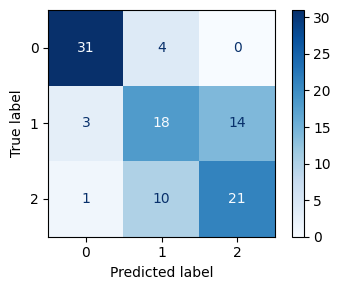

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract the true labels and predictions
y_true = testset['label']
y_pred = testset['logreg_prediction']

# Get the unique class labels (in case they're not 0, 1, 2...)
classes = np.unique(np.concatenate([y_true, y_pred]))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with proper labels
fig, ax = plt.subplots(figsize=(4, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', ax=ax)

plt.title('')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

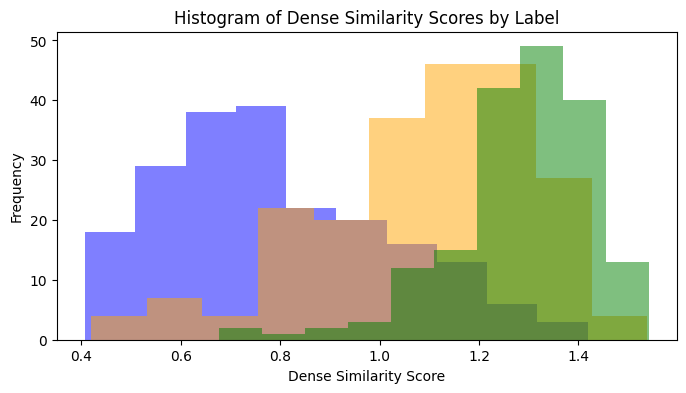

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# histogram of dense similarity of each label
classes = np.unique(trainset['label'])
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(8, 4))
for i, label in enumerate(classes):
    plt.hist(trainset[trainset['label'] == label]['top_dense_score'], bins=10, alpha=0.5, label=f'label {label}', color=colors[i])
plt.title('Histogram of Dense Similarity Scores by Label')
plt.xlabel('Dense Similarity Score')
plt.ylabel('Frequency')

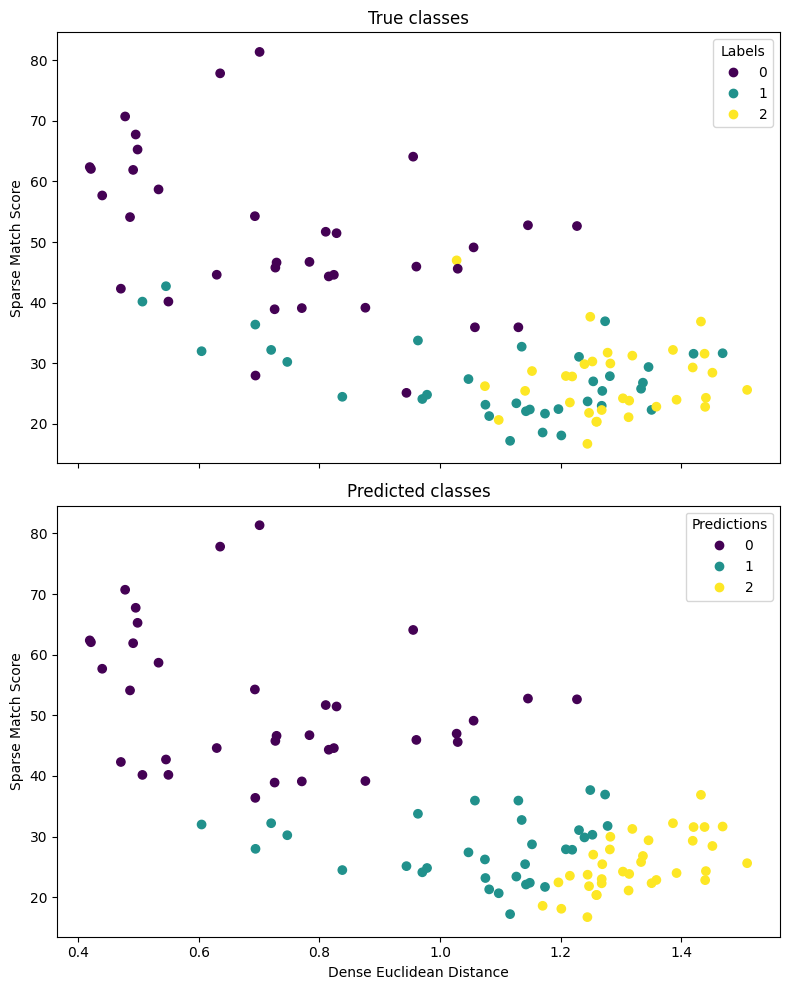

In [15]:
# Scatter plot dense against sparse similarity with label as color
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Plot 1: Using label as color
scatter1 = axs[0].scatter(testset['top_dense_score'], testset['top_sparse_score'], c=testset['label'], cmap='viridis')
axs[0].set_title('True classes')
axs[0].set_ylabel('Sparse Match Score')
axs[0].legend(*scatter1.legend_elements(), title="Labels")

# Plot 2: Using logreg_prediction as color
scatter2 = axs[1].scatter(testset['top_dense_score'], testset['top_sparse_score'], c=testset['logreg_prediction'], cmap='viridis')
axs[1].set_title('Predicted classes')
axs[1].set_xlabel('Dense Euclidean Distance')
axs[1].set_ylabel('Sparse Match Score')
axs[1].legend(*scatter2.legend_elements(), title="Predictions")

plt.tight_layout()
plt.show()


In [256]:
(testset[testset['label'] == 0]['top_dense_score'].mean(),
testset[testset['label'] == 1]['top_dense_score'].mean(),
testset[testset['label'] == 2]['top_dense_score'].mean())

(np.float32(0.7438403), np.float32(1.0555464), np.float32(1.196993))

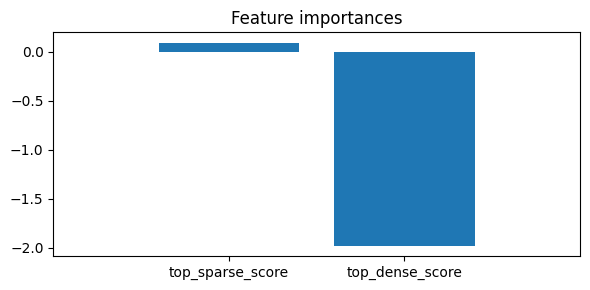

In [232]:
# feature importance
importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else model.coef_[0]
indices = np.argsort(importances)[::-1]
feature_names = features
plt.figure(figsize=(6, 3))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=0)
plt.xlim([-1, len(importances)])
plt.tight_layout()

In [233]:
# Get the coefficients from the trained model
coefficients = model.coef_[0]

# Combine into a DataFrame for readability
feature_importance = pd.DataFrame({
    'feature': features,
    'coefficient': coefficients
}).sort_values(by='coefficient', key=abs, ascending=False)

print(feature_importance)

            feature  coefficient
1   top_dense_score    -1.982764
0  top_sparse_score     0.093102


## Eval counterfactual

In [245]:
rag = RAG(scope_model_id='73e8819c680c49b2a511a5efbe04876b')

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading default flashrank model for language en
Default Model: ms-marco-MiniLM-L-12-v2
Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...
Successfully loaded model from run 73e8819c680c49b2a511a5efbe04876b
Loaded features: ['top_sparse_score', 'top_dense_score']


In [246]:
df_counterfactual = testset[testset['logreg_prediction'] == 0].sample(2)
responses = df_counterfactual['question'].apply(lambda q: rag.query(q))

Batches: 100%|██████████| 1/1 [00:00<00:00, 43.27it/s]


Features for scope prediction: [np.float64(39.979456141031605), np.float32(0.6349304)]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 43.87it/s]


Features for scope prediction: [np.float64(51.45890480528656), np.float32(0.82841694)]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [249]:
responses[10]

{'chunks': [{'filename': 'business_174',
   'text': "“RBI, through its communication dated September 19, 2024, has lifted the restrictions imposed on the gold loan business of the company. The RBI’s decision is effective immediately,” IIFL Finance said in a stock exchange filing.\n\nThe private sector non-banking financial company (NBFC) said that the RBI's decision is effective immediately and allows it to resume providing gold loans, according to the regulatory filing.\n\nThe Reserve Bank had imposed the restrictions on the company's unit on March 4, prohibiting the NBFC from “sanctioning, disbursing, or assigning/securitising/selling any of its gold loans”.\n\nIIFL came under regulatory scrutiny amid a crackdown on financial firms. RBI had instructed it to halt new gold-backed lending due to “material supervisory concerns”. Over the past months, IIFL took corrective actions to address the issues raised by the regulator.\n\nThe lifting of the ban comes as a big relief for IIFL, a maj

In [240]:
[response['counterfactual'] for response in responses]

KeyError: 'counterfactual'